# **GROUP PROJECT**

https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-74759-0_345

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import geopandas as gpd
import random
from deap import base, creator, tools
import pyproj
from shapely.geometry import Point, LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ortools as ort
import datetime as dt
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

C:\Users\Noah\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# **1. Problem Variables**

In [2]:
# truck variables
truckRange = 10
truckCapacity = 500
nCities = 30
M = 10

# **2. SET UP CITIES**

In [3]:
def buildCityDF(nCities,gridX=100,gridY=100):
    xs = np.random.randint(0,gridX,nCities)
    ys = np.random.randint(0,gridY,nCities)
    pts = [Point(xs[i],ys[i]) for i in range(0,nCities)]
    demands = np.random.randint(0,101,nCities)
    facilityOneCosts = np.random.randint(0,101,nCities)
    facilityTwoCosts = np.random.randint(100,201,nCities)
    cityIndices = range(0,nCities)
    cities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts})
    return cities

In [4]:
def buildDistanceMatrix_Euclidean(cities):
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    return distances

In [5]:
cities = buildCityDF(nCities)

In [6]:
def assignFacilitiesAndCluster(cities,M = 100,Rv=100,alpha=75.0):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()

    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(2)} # charging station location decision/ concentrator
    
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(2)]
    
    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(2)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(2)]) <= M)
        
    # Total tour length constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= Rv)
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(2)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

In [7]:
model,yjz,xij,resultGDF,status = assignFacilitiesAndCluster(cities,M=30,Rv=100,alpha=0.001)

Optimal Solution Found


Text(721.4, 0.5, 'City')

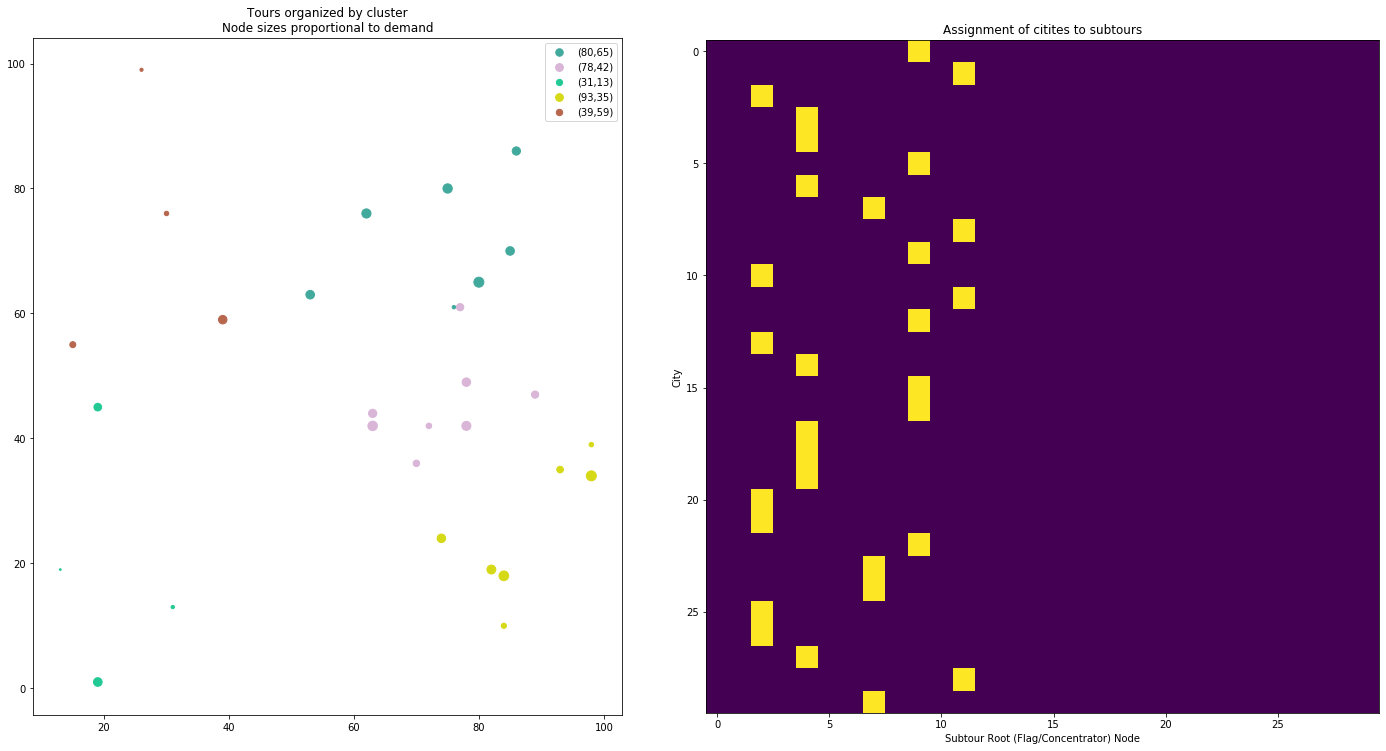

In [8]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y})")
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

# **3. SOLVE TSP SUB-TOURS**

In [9]:
def convertTourToPathDF(tour,resultGDF):
#     tour = list(resultGDF[resultGDF["assignment"]==tour]["City Index"])
    tour.append(tour[0]) # Return to end
    startNodes = []
    endNodes = []
    startCoords = []
    endCoords = []
    lines = [] # https://gis.stackexchange.com/questions/95670/how-to-create-a-shapely-linestring-from-two-points
    for i in range(0,len(tour)):
        currentCity = tour[i]
        if i < len(tour)-1:
            nextCity = tour[i+1]
        else:
            nextCity = tour[0]
        startNodes.append(currentCity)
        endNodes.append(nextCity)
        startPoint = resultGDF[resultGDF["City Index"]==currentCity].geometry
        startCoords.append(startPoint)
        endPoint = resultGDF[resultGDF["City Index"]==nextCity].geometry
        endCoords.append(endPoint)
        line = LineString([(startPoint.x,startPoint.y),(endPoint.x,endPoint.y)])
        lines.append(line)
    gdf = gpd.GeoDataFrame({"Start Node":startNodes,"End Node":endNodes,"geometry":lines})
    return gdf

In [10]:
# https://developers.google.com/optimization/routing/tsp
"""Simple travelling salesman problem between cities."""

def create_data_model(dfSubset):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = buildDistanceMatrix_Euclidean(dfSubset.reset_index())
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, assignment,dfSubset):
    """Prints assignment on console."""
    optimizedRoute = []
    print('Objective: {} miles'.format(assignment.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    orderedDFSubset = dfSubset.reset_index()
    while not routing.IsEnd(index):
        correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
        optimizedRoute.append(correctedCityIndex)
#         print(f"******{correctedCityIndex}")
#         print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
#     print(f"******{correctedCityIndex}")
    optimizedRoute.append(correctedCityIndex)
#     print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    return optimizedRoute,route_distance


def main(dfSubset):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(dfSubset)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        route,route_distance = print_solution(manager, routing, assignment,dfSubset)
    return route,route_distance

Objective: 91 miles
Route for vehicle 0:
 0 -> 6 -> 5 -> 4 -> 2 -> 1 -> 3 -> 0

Objective: 80 miles
Route for vehicle 0:
 0 -> 7 -> 1 -> 3 -> 4 -> 5 -> 2 -> 6 -> 0

Objective: 94 miles
Route for vehicle 0:
 0 -> 1 -> 3 -> 2 -> 0

Objective: 78 miles
Route for vehicle 0:
 0 -> 4 -> 3 -> 5 -> 6 -> 2 -> 1 -> 0

Objective: 111 miles
Route for vehicle 0:
 0 -> 2 -> 3 -> 1 -> 0



Text(721.4, 0.5, 'City')

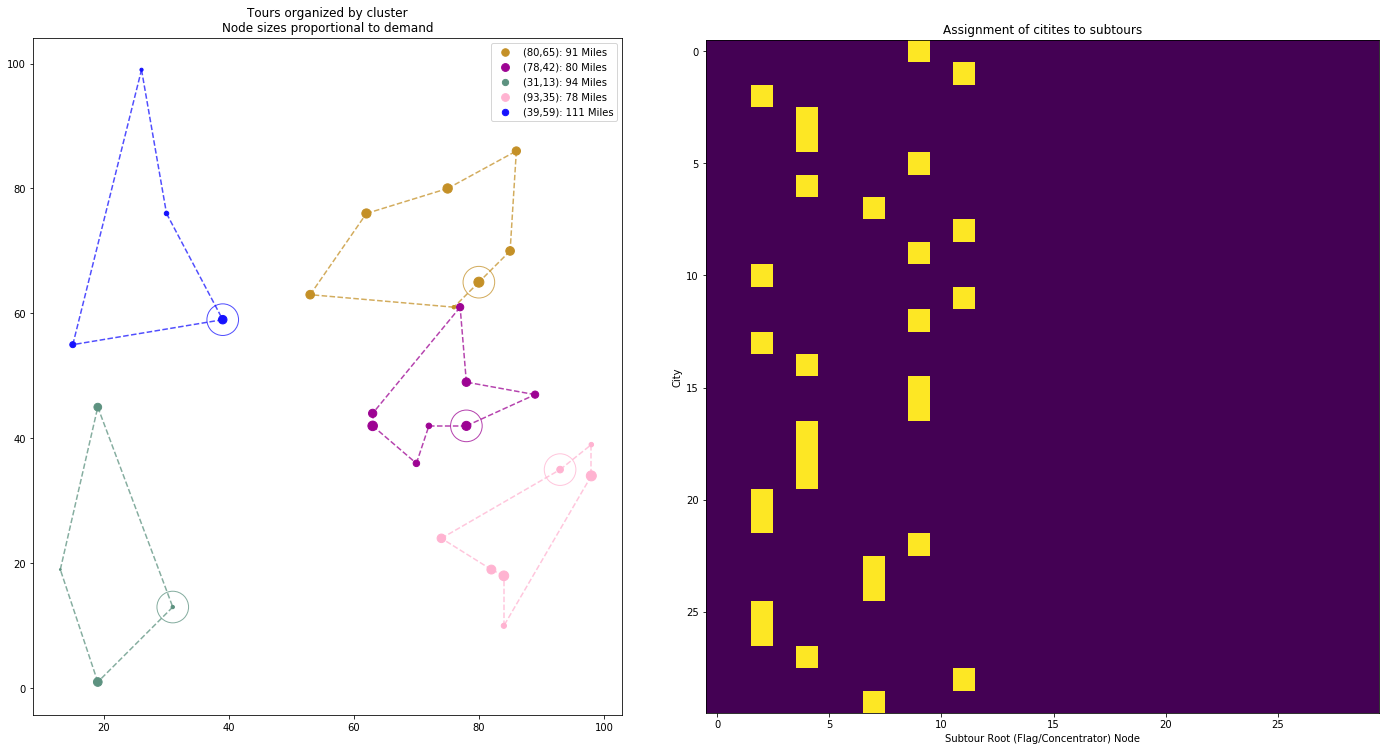

In [31]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    label = f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y}): {tourLength} Miles"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=label)
    # plot the tour
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls="dashed",alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

# **A) CLEAN UP, CLEAN UP, EVERYBODY EVERYWHERE**

By Tomorrow
- TSP code  with GA
- Test segementation code for size, loop through and see how long it takes to run

# **CHECK HOW LARGE WE CAN DO**

In [ ]:
nCities = range(10,110,10)
gridX = 100
gridY = 100

In [ ]:
times = []
for nCity in nCities:
    startTime = dt.datetime.now()
    cities = buildCityDF(nCity,gridX=100,gridY=100)
    m,yj,xij,resultGDF,status = solveOriginal(cities)
    endTime = dt.datetime.now()
    totalTime = (endTime-startTime).total_seconds()
    times.append(totalTime)
    print(f"Completed {nCity} cities in {totalTime} seconds.  Optimal solution: {status == pywraplp.Solver.OPTIMAL}")

In [51]:
illinoisCitiesPath = "Final Presentation\\tl_2016_17_place\\tl_2016_17_place.shp"
illinoisCitiesPath = "Final Presentation\\illinois_projected.shp"
illinois = gpd.read_file(illinoisCitiesPath)

CPLE_OpenFailedError: Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.

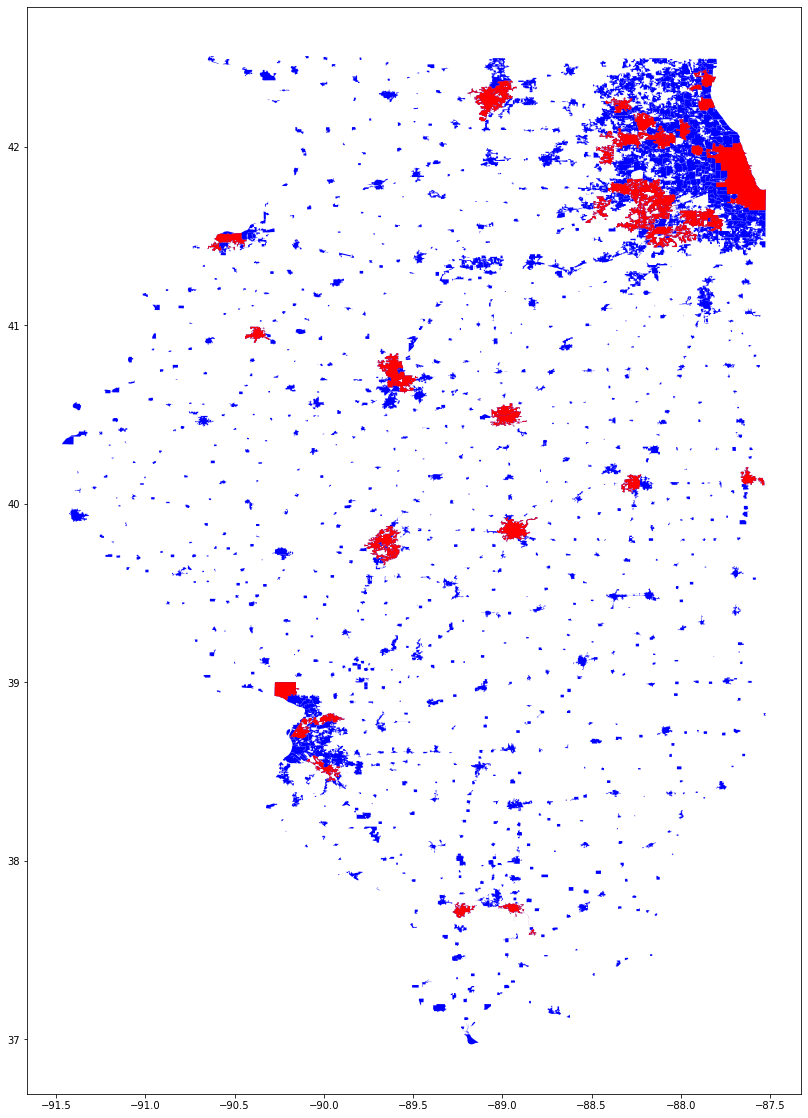

In [13]:
fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].plot(ax=ax,color="red")

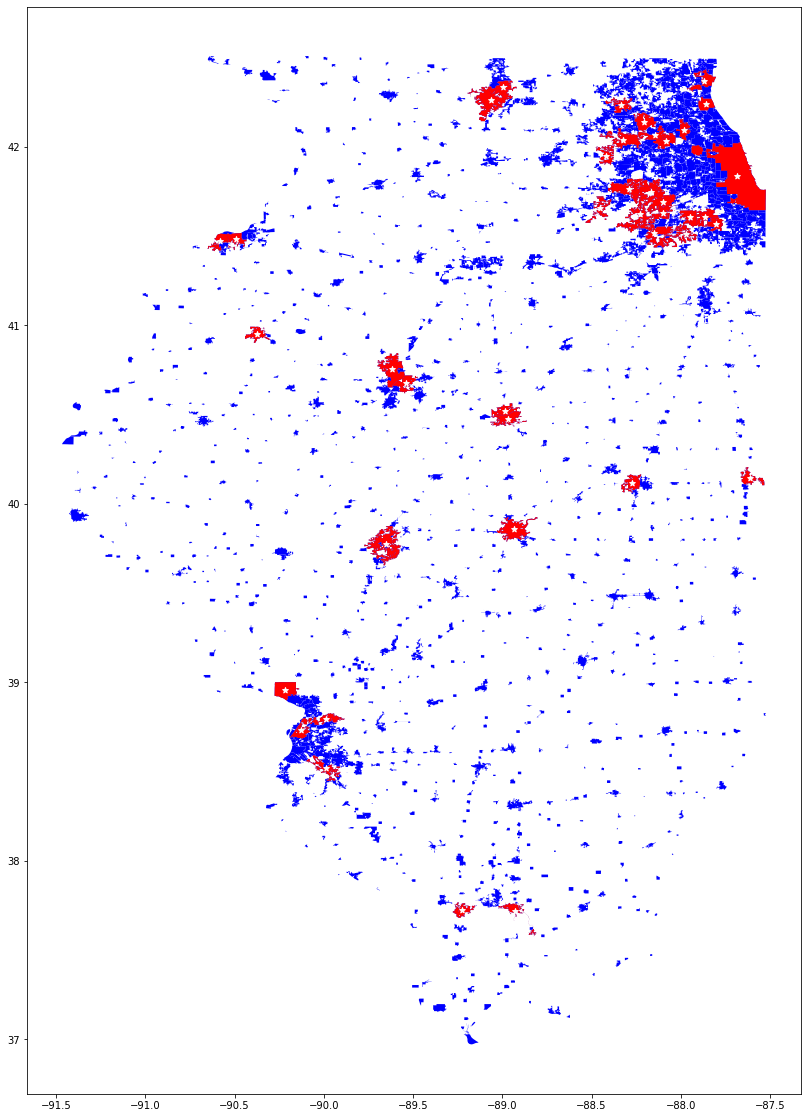

In [18]:
fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].plot(ax=ax,color="red")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax,color="white",marker='*')

fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].plot(ax=ax,color="red")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax,color="white",%%sh)

In [21]:
cities_illinois = illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid

In [36]:
illinois.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,37621,02398579,1737621,Iola,Iola village,47,C1,N,N,G4110,A,2525074,0,+38.8340047,-088.6278347,"POLYGON ((-88.63779 38.830653, -88.63765699999..."
1,17,28807,02398948,1728807,Gays,Gays village,47,C1,N,N,G4110,A,1053451,0,+39.4581569,-088.4963203,"POLYGON ((-88.50366799999999 39.462022, -88.50..."
2,17,56627,02399585,1756627,Orland Hills,Orland Hills village,47,C1,N,N,G4110,A,2965354,19721,+41.5911743,-087.8415395,"(POLYGON ((-87.852374 41.586738, -87.852312 41..."
3,17,04247,02398053,1704247,Baylis,Baylis village,47,C1,N,N,G4110,A,1213688,0,+39.7294385,-090.9092821,"POLYGON ((-90.915992 39.728927, -90.9159059999..."
4,17,26480,02398886,1726480,Florence,Florence village,47,C1,N,N,G4110,A,539809,0,+39.6286917,-090.6106967,"POLYGON ((-90.614105 39.634804, -90.613766 39...."


In [42]:
nCities = 20
facilityOneBaseCost = 100000
facilityOneBaseSTD = 10000
facilityTwoBaseCost = 1000000
facilityTwoBaseSTD = 100000
baseDemand = 10000
baseDemandSTD = 10000
demands = np.random.normal(baseDemand, baseDemandSTD, nCities)
facilityOneCosts = np.random.normal(facilityOneBaseCost, facilityOneBaseSTD, nCities)
facilityTwoCosts = np.random.normal(facilityTwoBaseCost, facilityTwoBaseSTD, nCities)
cityIndices = range(nCities)
xs = []
ys = []
pts = []
polygons = []
for i,row in illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].iterrows():
    pts.append(row["geometry"].centroid)
    polygons.append(row["geometry"])
    xs.append(row["geometry"].centroid.x)
    ys.append(row["geometry"].centroid.y)


illinoisCities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"polygon":polygons,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts})





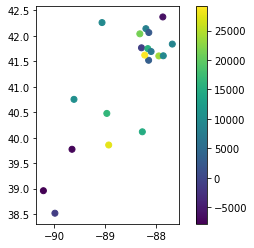

In [45]:
illinoisCities.plot("demand",legend=True)